In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform, euclidean # Foi adicionado o 'euclidean' (Eduardo)

In [2]:
def distance_corr(var_1, var_2, normedweight, power): # Função otimizada para calcular o 'disco' (Eduardo)
    
    xx = np.reshape(var_1, (-1, 1))
    xx = np.tile(xx, (1, len(var_1)))
    yy = np.tile(var_1, (len(var_1), 1))
    amat = abs(xx-yy)
    
    xx = np.reshape(var_2, (-1, 1))
    xx = np.tile(xx, (1, len(var_2)))
    yy = np.tile(var_2, (len(var_2), 1))
    bmat = abs(xx-yy)

    amatavg = np.mean(amat*normedweight, axis=1)
    amat1 = np.tile(amatavg, (len(var_1), 1))
    amat2 = np.reshape(amatavg, (-1, 1))
    amat2 = np.tile(amat2, (1, len(var_1)))
    amat3 = np.mean(amatavg*normedweight, axis=0)
    Amat = amat - amat1 - amat2 + amat3

    bmatavg = np.mean(bmat*normedweight, axis=1)
    bmat1 = np.tile(bmatavg, (len(var_2), 1))
    bmat2 = np.reshape(bmatavg, (-1, 1))
    bmat2 = np.tile(bmat2, (1, len(var_2)))
    bmat3 = np.mean(bmatavg*normedweight, axis=0)
    Bmat = bmat - bmat1 - bmat2 + bmat3

    ABavg = np.mean(Amat*Bmat*normedweight, axis=1)
    AAavg = np.mean(Amat*Amat*normedweight, axis=1)
    BBavg = np.mean(Bmat*Bmat*normedweight, axis=1)
    
    if(power==1):
        dCorr=(np.mean(ABavg*normedweight))/np.sqrt((np.mean(AAavg*normedweight)*np.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(np.mean(ABavg*normedweight))**2/(np.mean(AAavg*normedweight)*np.mean(BBavg*normedweight))
    else:
        dCorr=((np.mean(ABavg*normedweight))/np.sqrt((np.mean(AAavg*normedweight)*np.mean(BBavg*normedweight))))**power
    
    return dCorr

In [3]:
def alternativa_cdist(matrizA, matrizB): # Uma função que possibilita realizar o 'cdist' de outra forma (Matheus)
    
    # Caso a variável 1 for uma lista, fazer a mudança para um 'np.array' (Eduardo)
    if type(matrizA) is list:
        matrizA = np.asarray(matrizA)
        A,B = matrizA.shape
        matrizA = matrizA.reshape(A,B)
    
    # Caso a variável 2 for uma lista, fazer a mudança para um 'np.array' (Eduardo)
    if type(matrizB) is list:
        matrizB = np.asarray(matrizB)
        A,B = matrizB.shape
        matrizB = matrizB.reshape(A,B)
    
    L1,_ = matrizA.shape
    L2,_ = matrizB.shape
    
    resultado = np.zeros((L1,L2))
    
    for i,a in enumerate(matrizA):
        for j,b in enumerate(matrizB):
            resultado[i,j] = euclidean(a,b)
            
    return resultado

In [4]:
def alternativa_pdist(matrizA): # Uma função que possibilita realizar o 'pdist' de outra forma (Matheus)
    
    # Caso a variável 1 for uma lista, fazer a mudança para um 'np.array' (Eduardo)
    if type(matrizA) is list:
        matrizA = np.asarray(matrizA)
        A,B = matrizA.shape
        matrizA = matrizA.reshape(A,B)
    
    L, W = matrizA.shape
    
    resultado = np.zeros((L**2+L-(L**2+3*L+2)//2)+1)
    
    for i in range(L):
        for j in range(i,L):
            if i != j:
                resultado[L * i + j - ((i + 2) * (i + 1)) // 2] = euclidean(matrizA[i], matrizA[j])
                
    return resultado

In [5]:
def grid_set(data, N):
    _ , W = data.shape
    AvD1 = data.mean(0)
    X1 = np.mean(np.sum(np.power(data,2),axis=1))
    grid_trad = np.sqrt(2*(X1 - AvD1*AvD1.T))/N
    Xnorm = np.sqrt(np.sum(np.power(data,2),axis=1))
    aux = Xnorm
    for i in range(W-1):
        aux = np.insert(aux,0,Xnorm.T,axis=1)
    data = data / aux
    seq = np.argwhere(np.isnan(data))
    if tuple(seq[::]): data[tuple(seq[::])] = 1
    AvD2 = data.mean(0)
    grid_angl = np.sqrt(1-AvD2*AvD2.T)/N
    return X1, AvD1, AvD2, grid_trad, grid_angl

In [6]:
def pi_calculator(Uniquesample, mode):
    UN, W = Uniquesample.shape
    if mode == 'euclidean':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)   
        aux2 = [Uniquesample[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.power(aux2,2),axis=1)+DT1
        
    if mode == 'mahalanobis' or mode == 'cityblock' or mode == 'chebyshev' or mode == 'canberra':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = []
        for i in range(UN): aux.append(AA1)   
        uspi = np.power(cdist(Uniquesample, aux, mode),2)+DT1
        uspi = uspi[:,0]
        
    elif mode == 'minkowski':
        AA1 = Uniquesample.mean(0)
        X1 = sum(sum(np.power(Uniquesample,2)))/UN
        DT1 = X1 - sum(np.power(AA1,2))
        aux = np.matrix(AA1)
        for i in range(UN-1): aux = np.insert(aux,0,AA1,axis=0)
        aux = np.array(aux)
        
        uspi = np.power(cdist(Uniquesample, aux, mode, p=1.5),2)+DT1
        uspi = uspi[:,0]
    
    elif mode == 'cosine':
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        aux2 = [Uniquesample1[i]-aux[i] for i in range(UN)]
        uspi = np.sum(np.sum(np.power(aux2,2),axis=1),axis=1)+DT2
        
    elif mode == 'correlation': # Adicionado o 'correlation' como um método de distância (Eduardo)
        # Etapas para o pi_calculator (artigo)
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        
        # Fazendo o 'aux' ter o mesmo tipo e as mesmas dimensões do 'Uniquesample' (Eduardo e Matheus)
        aux = np.asarray(aux)
        a,b,c = aux.shape
        aux = aux.reshape(a,c)
        
        # Calculando o 'uspi' através do 'cdist' (Eduardo)
        uspi = np.power(cdist(Uniquesample, aux, mode),2)+DT2
        uspi = uspi[:,0]
        
    elif mode == 'disco': # Adicionado o 'disco' como um método de distância (Eduardo)
        # Etapas para o pi_calculator (artigo)
        Xnorm = np.matrix(np.sqrt(np.sum(np.power(Uniquesample,2),axis=1))).T
        aux2 = Xnorm
        for i in range(W-1):
            aux2 = np.insert(aux2,0,Xnorm.T,axis=1)
        Uniquesample1 = Uniquesample / aux2
        AA2 = np.mean(Uniquesample1,0)
        X2 = 1
        DT2 = X2 - np.sum(np.power(AA2,2))
        aux = []
        for i in range(UN): aux.append(AA2)
        
        # Definindo os dados
        n = np.ones(UN)
        p = 1
        uspi = []
        
        # Fazendo o 'aux' ter o mesmo tipo e as mesmas dimensões do 'Uniquesample' (Eduardo e Matheus)
        aux = np.asarray(aux)
        a,b,c = aux.shape
        aux = aux.reshape(a,c)
        
        # Calculando o 'uspi', passando por todos os termos (Eduardo)
        for i in range(UN):
            aux2 = np.power(distance_corr(Uniquesample[i], aux[i], n[i], p),2)+DT2
            uspi.append(aux2)
            
        # Transformando o 'uspi' de uma lista para 'numpy.ndarray', assim como os demais 'uspi' (Eduardo)
        uspi = np.asarray(uspi)
        
    return uspi

In [7]:
def Globaldensity_Calculator(data, distancetype, angulartype): # Adicionado o 'angulartype' (Eduardo)
    Uniquesample, J, K = np.unique(data, axis=0, return_index=True, return_inverse=True)
    Frequency, _ = np.histogram(K,bins=len(J))
    uspi1 = pi_calculator(Uniquesample, distancetype)
    sum_uspi1 = sum(uspi1)
    Density_1 = uspi1 / sum_uspi1
    uspi2 = pi_calculator(Uniquesample, angulartype) # Foi substituído pelo 'angulartype' (Eduardo)
    sum_uspi2 = sum(uspi2)
    Density_2 = uspi2 / sum_uspi2
    GD = (Density_2+Density_1) * Frequency
    index = GD.argsort()[::-1]
    GD = GD[index]
    Uniquesample = Uniquesample[index]
    Frequency = Frequency[index]
    return GD, Uniquesample, Frequency

In [8]:
def chessboard_division(Uniquesample, MMtypicality, interval1, interval2, distancetype, angulartype): # 'angulartype' (Eduardo)
    L, W = Uniquesample.shape
    if distancetype == 'euclidean':
        W = 1
    BOX = [Uniquesample[k] for k in range(W)]
    BOX_miu = [Uniquesample[k] for k in range(W)]
    BOX_S = [1]*W
    BOX_X = [sum(Uniquesample[k]**2) for k in range(W)]
    NB = W
    BOXMT = [MMtypicality[k] for k in range(W)]
    
    for i in range(W,L):
        if distancetype == 'minkowski':
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype, p=1.5)
        else:
            a = cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=distancetype)
        
        if angulartype == 'cosine' or angulartype == 'correlation': # Foi adicionado um 'if' para o coseno e 'correlation' (Eduardo)
            b = np.sqrt(cdist(Uniquesample[i].reshape(1,-1), BOX_miu, metric=angulartype)) # Substitído pelo 'angulartype' (Eduardo)
        else: # Foi adicionado um 'else' para o disco (Eduardo)
            b = np.sqrt(alternativa_cdist(Uniquesample[i].reshape(1,-1), BOX_miu)) # Forma de cálculo para o 'disco' (Eduardo)
            
        distance = np.array([a[0],b[0]]).T
        SQ = []
        for j,d in enumerate(distance):
            if d[0] < interval1 and d[1] < interval2:
                SQ.append(j)
        #SQ = np.argwhere(distance[::,0]<interval1 and (distance[::,1]<interval2))
        COUNT = len(SQ)
        if COUNT == 0:
            BOX.append(Uniquesample[i])
            NB = NB + 1
            BOX_S.append(1)
            BOX_miu.append(Uniquesample[i])
            BOX_X.append(sum(Uniquesample[i]**2))
            BOXMT.append(MMtypicality[i])
        if COUNT >= 1:
            DIS = distance[SQ[::],0]/interval1 + distance[SQ[::],1]/interval2
            b = np.argmin(DIS)
            BOX_S[SQ[b]] = BOX_S[SQ[b]] + 1
            BOX_miu[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_miu[SQ[b]] + Uniquesample[i]/BOX_S[SQ[b]]
            BOX_X[SQ[b]] = (BOX_S[SQ[b]]-1)/BOX_S[SQ[b]]*BOX_X[SQ[b]] + sum(Uniquesample[i]**2)/BOX_S[SQ[b]]
            BOXMT[SQ[b]] = BOXMT[SQ[b]] + MMtypicality[i]
    return BOX, BOX_miu, BOX_X, BOX_S, BOXMT, NB

In [9]:
def ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,Internval1,Internval2, distancetype, angulartype): # 'angulartype' (Eduardo)
    Centers = []
    n = 2
    ModeNumber = 0
    
    if distancetype == 'minkowski':
        distance1 = squareform(pdist(BOX_miu,metric=distancetype, p=1.5))
    else:
        distance1 = squareform(pdist(BOX_miu,metric=distancetype))        
    
    if angulartype == 'cosine' or angulartype == 'correlation': # Foi adicionado um 'if' para o coseno e 'correlation' (Eduardo): # Foi adicionado um 'if' para o coseno (Eduardo)
        distance2 = np.sqrt(squareform(pdist(BOX_miu,metric=angulartype)))
    else: # Foi adicionado um 'else' para o disco (Eduardo)
        distance2 = np.sqrt(squareform(alternativa_pdist(BOX_miu))) # Forma de cálculo para o 'disco' (Eduardo)
    
    for i in range(NB):
        seq = []
        for j,(d1,d2) in enumerate(zip(distance1[i],distance2[i])):
            if d1 < n*Internval1 and d2 < n*Internval2:
                seq.append(j)
        Chessblocak_typicality = [BOXMT[j] for j in seq]
        if max(Chessblocak_typicality) == BOXMT[i]:
            Centers.append(BOX_miu[i])
            ModeNumber = ModeNumber + 1
    return Centers, ModeNumber

In [10]:
def cloud_member_recruitment(ModelNumber,Center_samples,Uniquesample,grid_trad,grid_angl, distancetype, angulartype): # 'angulartype' (Eduardo)
    L, W = Uniquesample.shape
    Membership = np.zeros((L,ModelNumber))
    Members = np.zeros((L,ModelNumber*W))
    Count = []

    if distancetype == 'minkowski':
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype, p=1.5)/grid_trad
    else:
        distance1 = cdist(Uniquesample,Center_samples, metric=distancetype)/grid_trad

    if angulartype == 'cosine' or angulartype == 'correlation': # Foi adicionado um 'if' para o coseno e 'correlation' (Eduardo): # Foi adicionado um 'if' para o coseno (Eduardo)
        distance2 = np.sqrt(cdist(Uniquesample, Center_samples, metric=angulartype))/grid_angl
    else: # Foi adicionado um 'else' para o disco (Eduardo)
        distance2 = np.sqrt(alternativa_cdist(Uniquesample, Center_samples))/grid_angl # Cálculo para o 'disco' (Eduardo)
        
    distance3 = distance1 + distance2
    B = distance3.argmin(1)
    for i in range(ModelNumber):
        seq = []
        for j,b in enumerate(B):
            if b == i:
                seq.append(j)
        Count.append(len(seq))
        Membership[:Count[i]:,i] = seq
        Members[:Count[i]:,W*i:W*(i+1)] = [Uniquesample[j] for j in seq]
    MemberNumber = Count
    return Members,MemberNumber,Membership,B 

In [11]:
def SelfOrganisedDirectionAwareDataPartitioning(Input, Mode):
    if Mode == 'Offline':
        data = Input['StaticData']
        L, W = data.shape
        N = Input['GridSize']
        distancetype = Input['DistanceType']
        angulartype = Input['AngularType'] # Eduardo
        X1, AvD1, AvD2, grid_trad, grid_angl = grid_set(data,N)
        GD, Uniquesample, Frequency = Globaldensity_Calculator(data, distancetype, angulartype)
        BOX,BOX_miu,BOX_X,BOX_S,BOXMT,NB = chessboard_division(Uniquesample,GD,grid_trad,grid_angl, distancetype, angulartype) # Eduardo
        Center,ModeNumber = ChessBoard_PeakIdentification(BOX_miu,BOXMT,NB,grid_trad,grid_angl, distancetype, angulartype) # Eduardo
        Members,Membernumber,Membership,IDX = cloud_member_recruitment(ModeNumber,Center,data,grid_trad,grid_angl, distancetype, angulartype) # Eduardo
        
        Boxparameter = {'BOX': BOX,
                'BOX_miu': BOX_miu,
                'BOX_S': BOX_S,
                'NB': NB,
                'XM': X1,
                'L': L,
                'AvM': AvD1,
                'AvA': AvD2,
                'GridSize': N}
        
    if Mode == 'Evolving':
        print(Mode)
    
    Output = {'C': Center,
              'IDX': IDX,
              'SystemParams': Boxparameter,
              'DistanceType': distancetype}
    return Output

##  Distance Metrics ##
### Offline Mode
##### - Magnitude
 - Euclidean: straight line between two points;
 - Mahalanobis: Multi-dimensional generalization of how many standard deviations away a point is from another;
 - Cityblock: Distance between two vectors if they could only move right angles (taxicab/manhattan);
 - Chebyshev: The greatest of difference between two vectors along any coordinate dimension;
 - Minkowski: Generalization of other distances dependent of a parameter $p$ (in this code $p=1.5$ ):
  - p = 1 $\rightarrow$ cityblock;
  - p = 2 $\rightarrow$ euclidean;
  - p = $\infty$ $\rightarrow$ chebyshev.
 - Canberra: Weighted version of Cityblock, the distinction is that the absolute difference between the variables of the two objects is divided by the sum of the absolute variable values prior to summing. It's more sensitive for points close to origin.
 
##### - Angular
 - Cossine Dissimilarity: Is one minus the cosine of the angle between two vectors
 - Distance Correlation: measure of association between non-linear random variables

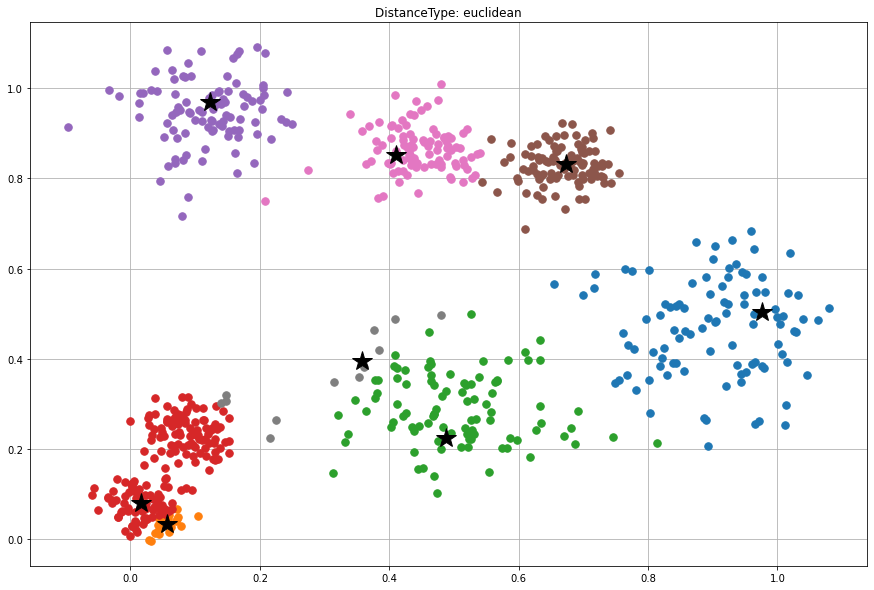

In [12]:
data = np.genfromtxt('exampledata.csv', delimiter=',')



data = np.matrix(data)
distances = ['euclidean']#,'euclidean', 'mahalanobis', 'cityblock', 'chebyshev', 'minkowski', 'canberra']
angular = ['correlation']# 'cosine', 'correlation', 'disco']    # Eduardo
output = []

granularity = 6

for d in distances:
    Input = {'GridSize':granularity, 'StaticData':data, 'DistanceType': d, 'AngularType': angular[0]} # Eduardo
    out = SelfOrganisedDirectionAwareDataPartitioning(Input,'Offline')
    output.append(out)
    
    fig = plt.figure(figsize=(15,10))
    T = np.unique(out['IDX'], axis=0)
    for t in T:
        seq = []
        for i, o in enumerate(out['IDX']):
            if o == t:
                seq.append(i)
        plt.plot(data[seq,0],data[seq,1], '.', linewidth=2, markersize=15)
    
    plt.title('DistanceType: {}'.format(d))
    plt.grid(which='both')
    plt.plot(np.array(out['C']).T[0],np.array(out['C']).T[1], 'k*', linewidth=2, markersize=20)